# XAI Interpretable Models

## Getting started

- Prepare the following file structure:
```text
XAI
|-- data
    |-- bike.csv
|-- 01_XAI_interpretable_models.ipynb
|-- requirements.txt
```
- Setup and activate virtual environment ([tutorial](https://realpython.com/python-virtual-environments-a-primer/))
- Install requirements: `pip install -r requirements.txt`
- Within the `XAI` directory, start the jupyter server: `jupyter notebook`
- Run notebook

In [ ]:
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from scipy.stats import norm

from utils import standardize_residuals, residual_analysis_plots

## Linear regression

This [blog article](https://drlee.io/explainable-ai-a-deep-dive-into-linear-regression-using-explainable-ai-techniques-1315464730ab) is also an interesting reference for the interpretability of linear regression.

### Linearity

In [ ]:
rng = np.random.default_rng(42)

n = 80

x_lin = np.linspace(0, 10, n)
y_lin = 10 + 15 * x_lin + rng.normal(0, 15, size=n)
X_lin = sm.add_constant(x_lin)          # add intercept
model_lin = sm.OLS(y_lin, X_lin).fit()
yhat_lin = model_lin.predict(X_lin)


x_non = np.linspace(0, 10, n)
y_non = x_non**4 + rng.normal(0, 300, size=n)
X_non = sm.add_constant(x_non)
model_non = sm.OLS(y_non, X_non).fit()
yhat_non = model_non.predict(X_non)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(x_lin, y_lin, alpha=0.7, edgecolor="white")
axes[0].plot(x_lin, yhat_lin, linewidth=2, color='red')
axes[0].set_title("Linearity holds")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

axes[1].scatter(x_non, y_non, alpha=0.7, edgecolor="white")
axes[1].plot(x_non, yhat_non, linewidth=2, color="red")
axes[1].set_title("Linearity violated")
axes[1].set_xlabel("x")

plt.tight_layout()

### Confidence interval

In [ ]:
# Define range for standard normal
x = np.linspace(-4, 4, 500)
y = norm.pdf(x)

# Critical value for 95% CI (two-sided)
z_crit = norm.ppf(0.975)

fig, ax = plt.subplots(figsize=(8, 4))

# Plot normal curve
ax.plot(x, y, 'k', linewidth=2)
ax.fill_between(x, y, 0, where=(x <= -z_crit), color="red", alpha=0.4, label="2.5%")
ax.fill_between(x, y, 0, where=(x >= z_crit), color="red", alpha=0.4)
ax.fill_between(x, y, 0, where=(x > -z_crit) & (x < z_crit), color="skyblue", alpha=0.4, label="95%")

# Mark critical values
ax.axvline(-z_crit, color="red", linestyle="--")
ax.axvline(z_crit, color="red", linestyle="--")

# Labels
ax.set_title("Critical values for 95% Confidence Interval", fontsize=12)
ax.set_xlabel("Z")
ax.set_ylabel("Density")
ax.text(-z_crit, 0.02, f"-{z_crit:.2f}", ha='center', color='red')
ax.text(z_crit, 0.02, f"{z_crit:.2f}", ha='center', color='red')

ax.legend()
plt.show()


### Normality

In [ ]:
rng = np.random.default_rng(42)
normal_residuals = rng.normal(0, 1, size=200)
residual_analysis_plots(standardize_residuals(normal_residuals))
non_normal_residuals = rng.standard_t(df=3, size=200)
residual_analysis_plots(standardize_residuals(non_normal_residuals))

### Homoscedasticity
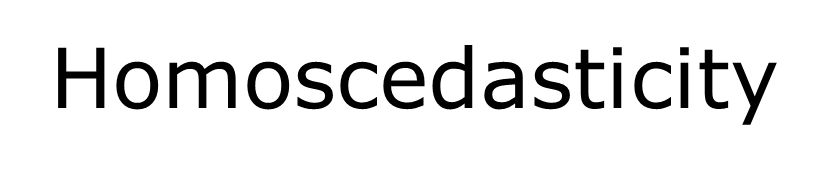

In [ ]:
rng = np.random.default_rng(42)
n = 200
x_lin = np.linspace(0, 10, n)
normal_residuals = rng.normal(0, 1, size=n)
heteroscedastic_residuals = rng.normal(0, 0.5 + 0.25 * x_lin)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].scatter(x_lin, normal_residuals, alpha=0.7, edgecolor="white")
axes[0].set_title("Homoscedastic residuals")

axes[1].scatter(x_lin, heteroscedastic_residuals, alpha=0.7, edgecolor="white")
axes[1].set_title("Heteroscedastic residuals")

plt.tight_layout()


### Case study - Predicting bike rentals

In [ ]:
bike = pd.read_csv('data/bike.csv')
bike_train, bike_test = train_test_split(bike, test_size=1/3, random_state=42)
bike_train.head()

In [ ]:
feature_cols = ['season','holiday', 'workday', 'weather', 'temp', 'hum', 'windspeed', 'cnt_2d_bfr']
target_col = 'cnt'
X = bike_train[feature_cols]
y = bike_train[target_col]
X = pd.get_dummies(X, columns=['season'], drop_first=True)
X['holiday'] = X['holiday'].apply(lambda x: x == 'Y')
X['workday'] = X['workday'].apply(lambda x: x == 'Y')
X['weather'] = X['weather'].apply(lambda x: x=='GOOD')
X = X.astype("float64")
X.head()

### Feature analysis

In [ ]:
sns.heatmap(X.corr(), cmap="coolwarm", fmt=".1f", vmin=-1, vmax=1,annot=True)
ticks = plt.xticks(rotation=45, ha='right')

### Fit linear regression model

In [ ]:
X = sm.add_constant(X)    # add intercept
model = sm.OLS(y, X).fit()
print(model.summary())

### Residual analysis

In [ ]:
residual_analysis_plots(standardize_residuals(model.resid), model.fittedvalues)

### Feature importance

In [ ]:
t_statistic = model.tvalues[1:] # exclude the constant
abs_t_statistic = abs(t_statistic)

plt.figure(figsize=(10, 5))
plt.bar(X.columns[1:], abs_t_statistic)

plt.ylabel('Absolute T-Statistic',size=15)
ticks = plt.xticks(rotation=45, ha='right')

### Weight plot

In [ ]:
coefficients = model.params[1:][::-1]
se = model.bse[1:][::-1]
features = X.columns[1:][::-1]

plt.figure(figsize=(10, 6))

plt.axvline(x=0, color='tab:red', linestyle='--')
plt.errorbar(coefficients,
             features,
             xerr=se*1.96,      # 95% CI
             fmt='o',
             capsize=5)
plt.title('Feature Weights with 95% Confidence Intervals')

### Effect plot

In [ ]:
feature_effects = X * model.params

# Combine feature effects for related features
feature_effects['season'] = feature_effects['season_SPRING'] + feature_effects['season_SUMMER'] + feature_effects['season_WINTER']
feature_effects.drop(['const','season_SPRING','season_SUMMER','season_WINTER'],axis=1,inplace=True)

plt.figure(figsize=(12, 7))
plt.axvline(x=0, color='tab:red', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue")
plt.xlabel("Effect on bike rentals")
plt.title("Feature Effects")

### Individual effect plot

In [ ]:
plt.figure(figsize=(12, 7))
plt.axvline(x=0, color='tab:red', linestyle='--')
sns.boxplot(data=feature_effects, orient="h", color="tab:Blue")
plt.xlabel("Effect on bike rentals")

idx = 42  # Any valid index in your dataset
ind_feature_effect = X.iloc[idx] * model.params

ind_feature_effect['season'] = ind_feature_effect['season_SPRING'] + ind_feature_effect['season_SUMMER'] + ind_feature_effect['season_WINTER']
ind_feature_effect.drop(['const','season_SPRING','season_SUMMER','season_WINTER'],inplace=True)

for i, feature in enumerate(ind_feature_effect):
    plt.scatter(feature, i, c='tab:red', marker='x', s=100, zorder=10)

plt.title(f"Individual feature effects for sample #{idx}: predicted {int(model.fittedvalues.iloc[idx])} bikes (target {y.iloc[idx]})")